In [1]:
import logging
import pickle
import argparse
import time
import sys
import numpy as np
import pandas as pd
import os
sys.path.append('../../fspn')
os.makedirs('logs', exist_ok=True)
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("logs/{}_{}.log".format("debug", time.strftime("%Y%m%d-%H%M%S"))),
        logging.StreamHandler()
    ])
logger = logging.getLogger(__name__)

In [3]:
from Evaluation.test_training import test_on_toy
from Structure.nodes import Context, bfs, Sum, Product, Factorize, Leaf, get_nodes_by_type, get_topological_order, get_parents
from Structure.StatisticalTypes import MetaType
from Structure.leaves.fspn_leaves.Merge_leaves import Merge_leaves
from Learning.validity import is_valid
from Inference.inference import prod_likelihood, sum_likelihood
from Structure.leaves.parametric.Parametric import Categorical, Gaussian
from Evaluation.toy_dataset import *
from Structure.model import FSPN

Loading GAS data. Make sure to unzip the "gas_data.zip" before running the next step

In [4]:
df = pd.read_hdf("gas_data/gas_discrete.hdf", key="dataframe")
print(len(df), len(df.columns))
df.head(3)

2021-06-24 11:24:26,727 [INFO ]  NumExpr defaulting to 8 threads.


3843159 8


,Time,Humidity,Temperature,Flow_rate,Heater_voltage,R1,R5,R7
0,0,36,37,61,13,30,10,8
1,0,36,37,61,12,38,14,13
2,0,36,37,61,11,45,24,20


Training an FSPN model, where rdc_sample_size, rdc_strong_connection_threshold, and threshold are there hyperparameters to tune.

In [8]:
from Learning.learningWrapper import learn_FSPN
from Structure.nodes import Context
from Structure.leaves.parametric.Parametric import Categorical, Gaussian
from Evaluation.toy_dataset import *
from Structure.model import FSPN
sample_data = df.to_numpy().astype(int)
parametric_types=[Categorical for i in range(len(df.columns))]
ds_context = Context(parametric_types=parametric_types).add_domains(sample_data)
fspn = learn_FSPN(sample_data, ds_context, rdc_sample_size=100000, rdc_strong_connection_threshold=0.7, 
                     multivariate_leaf=False, threshold=0.3)

2021-06-24 11:29:31,276 [DEBUG]  Current task with data (3843159, 8) scope [0, 1, 2, 3, 4, 5, 6, 7] and condition []
2021-06-24 11:29:37,154 [DEBUG]  calculating pairwise RDC on sample 100000 takes 5.671025991439819 secs
2021-06-24 11:29:37,155 [DEBUG]  OP: Operation.SPLIT_COLUMNS on slice (3843159, 8) (remaining tasks 0)
2021-06-24 11:29:37,333 [DEBUG]  		found 5 col clusters (in 0.17723 secs)
2021-06-24 11:29:37,334 [DEBUG]  Create an independent component with scope [0] and condition []
2021-06-24 11:29:37,335 [DEBUG]  Create an independent component with scope [1] and condition []
2021-06-24 11:29:37,336 [DEBUG]  Create an independent component with scope [2] and condition []
2021-06-24 11:29:37,336 [DEBUG]  Create an independent component with scope [3] and condition []
2021-06-24 11:29:37,337 [DEBUG]  Create an independent component with scope [4, 5, 6, 7] and condition []
2021-06-24 11:29:37,338 [DEBUG]  Current task with data (3843159, 1) scope [0] and condition []
2021-06-24 1

2021-06-24 11:30:06,906 [INFO ]  find optimal clusters: [{5: [(0, 5)]}, {5: [(6.0, 13)]}]
2021-06-24 11:30:06,995 [DEBUG]  		found 2 row clusters (in 0.19432 secs)
2021-06-24 11:30:06,999 [DEBUG]  Current task with data (968085, 4) scope [4, 6, 7] and condition [5]
2021-06-24 11:30:09,752 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.667807102203369 secs
2021-06-24 11:30:09,755 [DEBUG]  OP: Operation.SPLIT_ROWS_CONDITION on slice (968085, 4) (remaining tasks 9)
2021-06-24 11:30:09,756 [DEBUG]  fanout_location [], condition_location [1], query_attr [1]
2021-06-24 11:30:09,758 [INFO ]  find optimal attribute: 5
2021-06-24 11:30:09,876 [INFO ]  find optimal clusters: [{5: [(14, 20)]}, {5: [(21.0, 34)]}]
2021-06-24 11:30:09,990 [DEBUG]  		found 2 row clusters (in 0.23334 secs)
2021-06-24 11:30:09,994 [DEBUG]  Current task with data (1008575, 1) scope [4] and condition []
2021-06-24 11:30:09,996 [DEBUG]  OP: Operation.CREATE_LEAF on slice (1008575, 1) (remaining tasks 10)
2021-

2021-06-24 11:30:45,253 [INFO ]  find optimal attribute: 5
2021-06-24 11:30:45,346 [INFO ]  find optimal clusters: [{5: [(22, 31)]}, {5: [(32.0, 35)]}]
2021-06-24 11:30:45,434 [DEBUG]  		found 2 row clusters (in 0.18329 secs)
2021-06-24 11:30:45,441 [DEBUG]  Current task with data (512962, 3) scope [6, 7] and condition [5]
2021-06-24 11:30:48,262 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.7203550338745117 secs
2021-06-24 11:30:48,264 [DEBUG]  OP: Operation.SPLIT_ROWS_CONDITION on slice (512962, 3) (remaining tasks 21)
2021-06-24 11:30:48,266 [DEBUG]  fanout_location [], condition_location [0], query_attr [0]
2021-06-24 11:30:48,268 [INFO ]  find optimal attribute: 5
2021-06-24 11:30:48,331 [INFO ]  find optimal clusters: [{5: [(36, 39)]}, {5: [(40.0, 43)]}]
2021-06-24 11:30:48,417 [DEBUG]  		found 2 row clusters (in 0.15066 secs)
2021-06-24 11:30:48,421 [DEBUG]  Current task with data (65236, 3) scope [6, 7] and condition [5]
2021-06-24 11:30:50,094 [DEBUG]  calculating

2021-06-24 11:31:27,531 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.8226141929626465 secs
2021-06-24 11:31:27,534 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (53008, 2) (remaining tasks 32)
2021-06-24 11:31:28,009 [DEBUG]  		found 2 row clusters (in 0.47201 secs)
2021-06-24 11:31:28,012 [DEBUG]  Current task with data (216420, 2) scope [4, 5] and condition []
2021-06-24 11:31:30,196 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.140510082244873 secs
2021-06-24 11:31:30,202 [DEBUG]  OP: Operation.SPLIT_COLUMNS on slice (216420, 2) (remaining tasks 33)
2021-06-24 11:31:30,217 [DEBUG]  		found 2 col clusters (in 0.01353 secs)
2021-06-24 11:31:30,218 [DEBUG]  Create an independent component with scope [4] and condition []
2021-06-24 11:31:30,220 [DEBUG]  Create an independent component with scope [5] and condition []
2021-06-24 11:31:30,224 [DEBUG]  Current task with data (78223, 2) scope [4, 5] and condition []
2021-06-24 11:31:31,736 [DEBUG]  calculating pairwis

2021-06-24 11:32:04,791 [DEBUG]  calculating pairwise RDC on sample 100000 takes 3.165390968322754 secs
2021-06-24 11:32:04,793 [DEBUG]  OP: Operation.SPLIT_ROWS_CONDITION on slice (191138, 4) (remaining tasks 40)
2021-06-24 11:32:04,794 [DEBUG]  fanout_location [], condition_location [1], query_attr [1]
2021-06-24 11:32:04,796 [INFO ]  find optimal attribute: 5
2021-06-24 11:32:04,829 [INFO ]  find optimal clusters: [{5: [(3, 3)]}, {5: [(4.0, 5)]}]
2021-06-24 11:32:04,854 [DEBUG]  		found 2 row clusters (in 0.05994 secs)
2021-06-24 11:32:04,857 [DEBUG]  Current task with data (65492, 4) scope [4, 6, 7] and condition [5]
2021-06-24 11:32:04,870 [DEBUG]  OP: Operation.REMOVE_UNINFORMATIVE_FEATURES on slice (65492, 4) (remaining tasks 41)
2021-06-24 11:32:04,871 [DEBUG]  find uninformation condition, keeping only condition []
2021-06-24 11:32:04,873 [DEBUG]  The rest scope [4, 6, 7] and condition [] keep
2021-06-24 11:32:04,876 [DEBUG]  Current task with data (129481, 4) scope [4, 6, 7] 

2021-06-24 11:32:38,908 [DEBUG]  OP: Operation.CREATE_LEAF on slice (216420, 1) (remaining tasks 43)
2021-06-24 11:32:38,930 [DEBUG]  		 created leaf Histogram for scope=[5] and condition=[] (in 0.02113 secs)
2021-06-24 11:32:38,933 [DEBUG]  Current task with data (30972, 2) scope [4, 5] and condition []
2021-06-24 11:32:38,934 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (30972, 2) (remaining tasks 42)
2021-06-24 11:32:38,945 [DEBUG]  		naive factorization 2 columns (in 0.00855 secs)
2021-06-24 11:32:38,946 [DEBUG]  Current task with data (47251, 2) scope [4, 5] and condition []
2021-06-24 11:32:39,660 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.7073009014129639 secs
2021-06-24 11:32:39,662 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (47251, 2) (remaining tasks 41)
2021-06-24 11:32:39,849 [DEBUG]  		found 2 row clusters (in 0.18552 secs)
2021-06-24 11:32:39,851 [DEBUG]  Current task with data (104364, 2) scope [4, 5] and condition []
2021-06-24 11:32:41,310 [DEBUG

2021-06-24 11:32:59,166 [INFO ]  find optimal clusters: [{4: [(10, 10)]}, {4: [(11.0, 12)]}]
2021-06-24 11:32:59,195 [DEBUG]  		found 2 row clusters (in 0.05941 secs)
2021-06-24 11:32:59,197 [DEBUG]  Current task with data (64612, 3) scope [4, 6, 7] and condition []
2021-06-24 11:32:59,199 [DEBUG]  OP: Operation.CREATE_LEAF on slice (64612, 3) (remaining tasks 41)
2021-06-24 11:32:59,223 [INFO ]  Multihistogram of size [21, 8, 7]
2021-06-24 11:32:59,247 [DEBUG]  		 created leaf Multi_histogram for scope=[4, 6, 7] and condition=[] (in 0.04558 secs)
2021-06-24 11:32:59,249 [DEBUG]  Current task with data (64417, 3) scope [4, 6, 7] and condition []
2021-06-24 11:32:59,252 [DEBUG]  OP: Operation.CREATE_LEAF on slice (64417, 3) (remaining tasks 40)
2021-06-24 11:32:59,269 [INFO ]  Multihistogram of size [22, 8, 7]
2021-06-24 11:32:59,285 [DEBUG]  		 created leaf Multi_histogram for scope=[4, 6, 7] and condition=[] (in 0.03089 secs)
2021-06-24 11:32:59,288 [DEBUG]  Current task with data (64

2021-06-24 11:33:06,821 [INFO ]  Multihistogram of size [14, 19, 13]
2021-06-24 11:33:06,850 [DEBUG]  		 created leaf Multi_histogram for scope=[4, 6, 7] and condition=[] (in 0.05320 secs)
2021-06-24 11:33:06,852 [DEBUG]  Current task with data (55056, 4) scope [4, 6, 7] and condition [5]
2021-06-24 11:33:06,862 [DEBUG]  OP: Operation.REMOVE_UNINFORMATIVE_FEATURES on slice (55056, 4) (remaining tasks 33)
2021-06-24 11:33:06,863 [DEBUG]  find uninformation condition, keeping only condition []
2021-06-24 11:33:06,865 [DEBUG]  The rest scope [4, 6, 7] and condition [] keep
2021-06-24 11:33:06,868 [DEBUG]  Current task with data (83677, 4) scope [4, 6, 7] and condition [5]
2021-06-24 11:33:09,409 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.52652907371521 secs
2021-06-24 11:33:09,410 [DEBUG]  OP: Operation.SPLIT_ROWS_CONDITION on slice (83677, 4) (remaining tasks 33)
2021-06-24 11:33:09,412 [DEBUG]  fanout_location [], condition_location [1], query_attr [1]
2021-06-24 11:33:0

2021-06-24 11:33:23,913 [DEBUG]  OP: Operation.SPLIT_ROWS_CONDITION on slice (74123, 3) (remaining tasks 30)
2021-06-24 11:33:23,915 [DEBUG]  fanout_location [], condition_location [0], query_attr [0]
2021-06-24 11:33:23,917 [INFO ]  find optimal attribute: 5
2021-06-24 11:33:23,932 [INFO ]  find optimal clusters: [{5: [(54, 56)]}, {5: [(57.0, 59)]}]
2021-06-24 11:33:23,947 [DEBUG]  		found 2 row clusters (in 0.03178 secs)
2021-06-24 11:33:23,950 [DEBUG]  Current task with data (99578, 3) scope [6, 7] and condition [5]
2021-06-24 11:33:26,100 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.1405718326568604 secs
2021-06-24 11:33:26,102 [DEBUG]  OP: Operation.SPLIT_ROWS_CONDITION on slice (99578, 3) (remaining tasks 31)
2021-06-24 11:33:26,103 [DEBUG]  fanout_location [], condition_location [0], query_attr [0]
2021-06-24 11:33:26,104 [INFO ]  find optimal attribute: 5
2021-06-24 11:33:26,118 [INFO ]  find optimal clusters: [{5: [(44, 56)]}, {5: [(57.0, 59)]}]
2021-06-24 11:33:

2021-06-24 11:33:30,428 [DEBUG]  		 created leaf Histogram for scope=[4] and condition=[] (in 0.00605 secs)
2021-06-24 11:33:30,430 [DEBUG]  Current task with data (38716, 1) scope [5] and condition []
2021-06-24 11:33:30,432 [DEBUG]  OP: Operation.CREATE_LEAF on slice (38716, 1) (remaining tasks 24)
2021-06-24 11:33:30,441 [DEBUG]  		 created leaf Histogram for scope=[5] and condition=[] (in 0.00782 secs)
2021-06-24 11:33:30,443 [DEBUG]  Current task with data (42513, 2) scope [6, 7] and condition []
2021-06-24 11:33:30,445 [DEBUG]  OP: Operation.CREATE_LEAF on slice (42513, 2) (remaining tasks 23)
2021-06-24 11:33:30,456 [INFO ]  Multihistogram of size [16, 15]
2021-06-24 11:33:30,465 [DEBUG]  		 created leaf Multi_histogram for scope=[6, 7] and condition=[] (in 0.01798 secs)
2021-06-24 11:33:30,467 [DEBUG]  Current task with data (134299, 2) scope [6, 7] and condition []
2021-06-24 11:33:30,469 [DEBUG]  OP: Operation.CREATE_LEAF on slice (134299, 2) (remaining tasks 22)
2021-06-24 1

2021-06-24 11:33:44,361 [DEBUG]  find uninformation condition, keeping only condition [5]
2021-06-24 11:33:44,364 [DEBUG]  Current task with data (64342, 3) scope [4, 6, 7] and condition []
2021-06-24 11:33:44,366 [DEBUG]  OP: Operation.CREATE_LEAF on slice (64342, 3) (remaining tasks 23)
2021-06-24 11:33:44,385 [INFO ]  Multihistogram of size [20, 8, 7]
2021-06-24 11:33:44,400 [DEBUG]  		 created leaf Multi_histogram for scope=[4, 6, 7] and condition=[] (in 0.03211 secs)
2021-06-24 11:33:44,405 [DEBUG]  Current task with data (63127, 3) scope [4, 6, 7] and condition []
2021-06-24 11:33:44,407 [DEBUG]  OP: Operation.CREATE_LEAF on slice (63127, 3) (remaining tasks 22)
2021-06-24 11:33:44,423 [INFO ]  Multihistogram of size [20, 8, 7]
2021-06-24 11:33:44,436 [DEBUG]  		 created leaf Multi_histogram for scope=[4, 6, 7] and condition=[] (in 0.02787 secs)
2021-06-24 11:33:44,439 [DEBUG]  Current task with data (62339, 3) scope [4, 6, 7] and condition []
2021-06-24 11:33:44,441 [DEBUG]  OP:

2021-06-24 11:33:49,169 [DEBUG]  OP: Operation.SPLIT_ROWS_CONDITION on slice (39198, 3) (remaining tasks 10)
2021-06-24 11:33:49,170 [DEBUG]  fanout_location [], condition_location [0], query_attr [0]
2021-06-24 11:33:49,172 [INFO ]  find optimal attribute: 5
2021-06-24 11:33:49,177 [INFO ]  find optimal clusters: [{5: [(58, 58)]}, {5: [(59, 59)]}]
2021-06-24 11:33:49,184 [DEBUG]  		found 2 row clusters (in 0.01407 secs)
2021-06-24 11:33:49,186 [DEBUG]  Current task with data (29028, 3) scope [6, 7] and condition [5]
2021-06-24 11:33:49,883 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.6915690898895264 secs
2021-06-24 11:33:49,884 [DEBUG]  OP: Operation.CREATE_LEAF on slice (29028, 3) (remaining tasks 11)
2021-06-24 11:33:49,892 [INFO ]  Multihistogram of size [13, 12]
2021-06-24 11:33:49,897 [DEBUG]  		 created leaf Multi_histogram for scope=[6, 7] and condition=[5] (in 0.01116 secs)
2021-06-24 11:33:49,899 [DEBUG]  Current task with data (37876, 3) scope [6, 7] and condi

2021-06-24 11:33:55,858 [INFO ]  Multihistogram of size [12, 9]
2021-06-24 11:33:55,863 [DEBUG]  		 created leaf Multi_histogram for scope=[6, 7] and condition=[] (in 0.01063 secs)
2021-06-24 11:33:55,865 [DEBUG]  Current task with data (19667, 2) scope [6, 7] and condition []
2021-06-24 11:33:55,867 [DEBUG]  OP: Operation.CREATE_LEAF on slice (19667, 2) (remaining tasks 3)
2021-06-24 11:33:55,874 [INFO ]  Multihistogram of size [12, 9]
2021-06-24 11:33:55,879 [DEBUG]  		 created leaf Multi_histogram for scope=[6, 7] and condition=[] (in 0.01004 secs)
2021-06-24 11:33:55,881 [DEBUG]  Current task with data (15909, 3) scope [6, 7] and condition [5]
2021-06-24 11:33:56,232 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.34485316276550293 secs
2021-06-24 11:33:56,234 [DEBUG]  OP: Operation.REMOVE_CONDITION on slice (15909, 3) (remaining tasks 2)
2021-06-24 11:33:56,237 [DEBUG]  Removed uniformative condition [5]
2021-06-24 11:33:56,240 [DEBUG]  Current task with data (27159, 3)

---Structure Statistics---
# nodes               221
    # sum nodes       74
    # factorize nodes 2
    # prod nodes      48
    # leaf nodes      97
# params              148
# edges               216
# layers              14


Training an SPN model as a baseline comparison. We set rdc_strong_connection_threshold > 1.0 to disable the factorize operation so FSPN in this case degenerates an SPN.

In [15]:
sample_data = df.to_numpy().astype(int)
parametric_types=[Categorical for i in range(len(df.columns))]
ds_context = Context(parametric_types=parametric_types).add_domains(sample_data)
spn = learn_FSPN(sample_data, ds_context, rdc_sample_size=100000, rdc_strong_connection_threshold=1.1, 
                     multivariate_leaf=False, threshold=0.3)

2021-06-24 11:42:27,038 [DEBUG]  Current task with data (3843159, 8) scope [0, 1, 2, 3, 4, 5, 6, 7] and condition []
2021-06-24 11:42:33,018 [DEBUG]  calculating pairwise RDC on sample 100000 takes 5.777498006820679 secs
2021-06-24 11:42:33,021 [DEBUG]  OP: Operation.SPLIT_COLUMNS on slice (3843159, 8) (remaining tasks 0)
2021-06-24 11:42:33,215 [DEBUG]  		found 5 col clusters (in 0.19300 secs)
2021-06-24 11:42:33,216 [DEBUG]  Create an independent component with scope [0] and condition []
2021-06-24 11:42:33,216 [DEBUG]  Create an independent component with scope [1] and condition []
2021-06-24 11:42:33,217 [DEBUG]  Create an independent component with scope [2] and condition []
2021-06-24 11:42:33,217 [DEBUG]  Create an independent component with scope [3] and condition []
2021-06-24 11:42:33,219 [DEBUG]  Create an independent component with scope [4, 5, 6, 7] and condition []
2021-06-24 11:42:33,219 [DEBUG]  Current task with data (3843159, 1) scope [0] and condition []
2021-06-24 1

2021-06-24 11:43:26,131 [DEBUG]  OP: Operation.SPLIT_COLUMNS on slice (518391, 3) (remaining tasks 11)
2021-06-24 11:43:26,144 [DEBUG]  		found 2 col clusters (in 0.01205 secs)
2021-06-24 11:43:26,145 [DEBUG]  Create an independent component with scope [5] and condition []
2021-06-24 11:43:26,146 [DEBUG]  Create an independent component with scope [6, 7] and condition []
2021-06-24 11:43:26,149 [DEBUG]  Current task with data (498267, 3) scope [5, 6, 7] and condition []
2021-06-24 11:43:28,190 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.9784808158874512 secs
2021-06-24 11:43:28,192 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (498267, 3) (remaining tasks 12)
2021-06-24 11:43:30,137 [DEBUG]  		found 2 row clusters (in 1.94307 secs)
2021-06-24 11:43:30,140 [DEBUG]  Current task with data (234251, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:43:32,948 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.786998987197876 secs
2021-06-24 11:43:32,952 [DEBUG]  OP: O

2021-06-24 11:44:35,750 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.1474192142486572 secs
2021-06-24 11:44:35,752 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (74219, 4) (remaining tasks 26)
2021-06-24 11:44:36,267 [DEBUG]  		found 2 row clusters (in 0.51378 secs)
2021-06-24 11:44:36,270 [DEBUG]  Current task with data (146610, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:44:39,316 [DEBUG]  calculating pairwise RDC on sample 100000 takes 3.024688959121704 secs
2021-06-24 11:44:39,319 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (146610, 4) (remaining tasks 27)
2021-06-24 11:44:40,739 [DEBUG]  		found 2 row clusters (in 1.41794 secs)
2021-06-24 11:44:40,741 [DEBUG]  Current task with data (80378, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:44:42,936 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.184915781021118 secs
2021-06-24 11:44:42,938 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (80378, 4) (remaining tasks 28)
2021-06-24 11:44:43,570 [DEBUG]  	

2021-06-24 11:45:39,250 [DEBUG]  		found 2 row clusters (in 0.79740 secs)
2021-06-24 11:45:39,252 [DEBUG]  Current task with data (73992, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:45:41,232 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.971195936203003 secs
2021-06-24 11:45:41,234 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (73992, 4) (remaining tasks 44)
2021-06-24 11:45:42,237 [DEBUG]  		found 2 row clusters (in 1.00111 secs)
2021-06-24 11:45:42,238 [DEBUG]  Current task with data (27806, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:45:42,239 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (27806, 4) (remaining tasks 45)
2021-06-24 11:45:42,255 [DEBUG]  		naive factorization 4 columns (in 0.01345 secs)
2021-06-24 11:45:42,256 [DEBUG]  Current task with data (43388, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:45:43,445 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.1809430122375488 secs
2021-06-24 11:45:43,447 [DEBUG]  OP: Operati

2021-06-24 11:46:22,250 [DEBUG]  Current task with data (86799, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:46:25,032 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.7686872482299805 secs
2021-06-24 11:46:25,034 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (86799, 4) (remaining tasks 59)
2021-06-24 11:46:25,601 [DEBUG]  		found 2 row clusters (in 0.56612 secs)
2021-06-24 11:46:25,604 [DEBUG]  Current task with data (97749, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:46:28,082 [DEBUG]  calculating pairwise RDC on sample 100000 takes 2.464325189590454 secs
2021-06-24 11:46:28,084 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (97749, 4) (remaining tasks 60)
2021-06-24 11:46:28,725 [DEBUG]  		found 2 row clusters (in 0.63956 secs)
2021-06-24 11:46:28,728 [DEBUG]  Current task with data (42114, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:46:29,846 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.1118628978729248 secs
2021-06-24 11:46:29,848 [DEBUG]

2021-06-24 11:46:57,452 [DEBUG]  		found 2 row clusters (in 0.72270 secs)
2021-06-24 11:46:57,454 [DEBUG]  Current task with data (53038, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:46:58,937 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.4757649898529053 secs
2021-06-24 11:46:58,938 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (53038, 4) (remaining tasks 71)
2021-06-24 11:46:59,276 [DEBUG]  		found 2 row clusters (in 0.33677 secs)
2021-06-24 11:46:59,278 [DEBUG]  Current task with data (59652, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:47:00,823 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.535719871520996 secs
2021-06-24 11:47:00,825 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (59652, 4) (remaining tasks 72)
2021-06-24 11:47:01,460 [DEBUG]  		found 2 row clusters (in 0.63288 secs)
2021-06-24 11:47:01,462 [DEBUG]  Current task with data (15809, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:47:01,463 [DEBUG]  OP: Operation.NAIVE_FACTORIZA

2021-06-24 11:47:15,059 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.3254129886627197 secs
2021-06-24 11:47:15,061 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (70204, 3) (remaining tasks 72)
2021-06-24 11:47:15,373 [DEBUG]  		found 2 row clusters (in 0.31068 secs)
2021-06-24 11:47:15,376 [DEBUG]  Current task with data (83409, 3) scope [5, 6, 7] and condition []
2021-06-24 11:47:16,972 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.5809378623962402 secs
2021-06-24 11:47:16,974 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (83409, 3) (remaining tasks 73)
2021-06-24 11:47:17,333 [DEBUG]  		found 2 row clusters (in 0.35729 secs)
2021-06-24 11:47:17,335 [DEBUG]  Current task with data (39590, 3) scope [5, 6, 7] and condition []
2021-06-24 11:47:18,139 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.7967960834503174 secs
2021-06-24 11:47:18,141 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (39590, 3) (remaining tasks 74)
2021-06-24 11:47:18,315 [DEBUG]  		found

2021-06-24 11:47:41,956 [DEBUG]  Current task with data (22504, 4) scope [4, 5, 6, 7] and condition []
2021-06-24 11:47:41,958 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (22504, 4) (remaining tasks 84)
2021-06-24 11:47:41,972 [DEBUG]  		naive factorization 4 columns (in 0.01181 secs)
2021-06-24 11:47:41,974 [DEBUG]  Current task with data (170438, 2) scope [4, 5] and condition []
2021-06-24 11:47:43,200 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.2209720611572266 secs
2021-06-24 11:47:43,201 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (170438, 2) (remaining tasks 83)
2021-06-24 11:47:43,731 [DEBUG]  		found 2 row clusters (in 0.52957 secs)
2021-06-24 11:47:43,733 [DEBUG]  Current task with data (170438, 2) scope [6, 7] and condition []
2021-06-24 11:47:44,674 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.9341821670532227 secs
2021-06-24 11:47:44,675 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (170438, 2) (remaining tasks 84)
2021-06-24 11:47:45,164 [D

2021-06-24 11:48:02,060 [DEBUG]  Current task with data (20751, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:02,061 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (20751, 3) (remaining tasks 93)
2021-06-24 11:48:02,071 [DEBUG]  		naive factorization 3 columns (in 0.00792 secs)
2021-06-24 11:48:02,072 [DEBUG]  Current task with data (24743, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:02,074 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (24743, 3) (remaining tasks 92)
2021-06-24 11:48:02,084 [DEBUG]  		naive factorization 3 columns (in 0.00891 secs)
2021-06-24 11:48:02,086 [DEBUG]  Current task with data (36360, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:02,088 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (36360, 3) (remaining tasks 91)
2021-06-24 11:48:02,102 [DEBUG]  		naive factorization 3 columns (in 0.01272 secs)
2021-06-24 11:48:02,104 [DEBUG]  Current task with data (57423, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:03,269 [DE

2021-06-24 11:48:15,468 [DEBUG]  Current task with data (73830, 1) scope [5] and condition []
2021-06-24 11:48:15,470 [DEBUG]  OP: Operation.CREATE_LEAF on slice (73830, 1) (remaining tasks 91)
2021-06-24 11:48:15,481 [DEBUG]  		 created leaf Histogram for scope=[5] and condition=[] (in 0.00913 secs)
2021-06-24 11:48:15,482 [DEBUG]  Current task with data (73830, 2) scope [6, 7] and condition []
2021-06-24 11:48:16,197 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.7109782695770264 secs
2021-06-24 11:48:16,198 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (73830, 2) (remaining tasks 90)
2021-06-24 11:48:16,447 [DEBUG]  		found 2 row clusters (in 0.24753 secs)
2021-06-24 11:48:16,450 [DEBUG]  Current task with data (34968, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:16,451 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (34968, 3) (remaining tasks 91)
2021-06-24 11:48:16,465 [DEBUG]  		naive factorization 3 columns (in 0.01219 secs)
2021-06-24 11:48:16,466 [DEBUG] 

2021-06-24 11:48:23,683 [DEBUG]  		naive factorization 3 columns (in 0.00760 secs)
2021-06-24 11:48:23,684 [DEBUG]  Current task with data (68810, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:24,996 [DEBUG]  calculating pairwise RDC on sample 100000 takes 1.3026113510131836 secs
2021-06-24 11:48:24,998 [DEBUG]  OP: Operation.SPLIT_COLUMNS on slice (68810, 3) (remaining tasks 79)
2021-06-24 11:48:25,001 [DEBUG]  		found 2 col clusters (in 0.00117 secs)
2021-06-24 11:48:25,003 [DEBUG]  Create an independent component with scope [5] and condition []
2021-06-24 11:48:25,005 [DEBUG]  Create an independent component with scope [6, 7] and condition []
2021-06-24 11:48:25,006 [DEBUG]  Current task with data (4450, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:25,008 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (4450, 3) (remaining tasks 80)
2021-06-24 11:48:25,014 [DEBUG]  		naive factorization 3 columns (in 0.00489 secs)
2021-06-24 11:48:25,016 [DEBUG]  Current task with

2021-06-24 11:48:37,558 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.5955562591552734 secs
2021-06-24 11:48:37,559 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (60102, 2) (remaining tasks 80)
2021-06-24 11:48:37,731 [DEBUG]  		found 2 row clusters (in 0.17085 secs)
2021-06-24 11:48:37,733 [DEBUG]  Current task with data (46415, 2) scope [6, 7] and condition []
2021-06-24 11:48:38,158 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.41943788528442383 secs
2021-06-24 11:48:38,160 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (46415, 2) (remaining tasks 81)
2021-06-24 11:48:38,320 [DEBUG]  		found 2 row clusters (in 0.15883 secs)
2021-06-24 11:48:38,322 [DEBUG]  Current task with data (78525, 2) scope [6, 7] and condition []
2021-06-24 11:48:39,049 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.7154488563537598 secs
2021-06-24 11:48:39,050 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (78525, 2) (remaining tasks 82)
2021-06-24 11:48:39,276 [DEBUG]  		found 2 ro

2021-06-24 11:48:42,208 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.7804937362670898 secs
2021-06-24 11:48:42,210 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (38908, 3) (remaining tasks 63)
2021-06-24 11:48:42,420 [DEBUG]  		found 2 row clusters (in 0.20838 secs)
2021-06-24 11:48:42,421 [DEBUG]  Current task with data (43641, 1) scope [4] and condition []
2021-06-24 11:48:42,422 [DEBUG]  OP: Operation.CREATE_LEAF on slice (43641, 1) (remaining tasks 64)
2021-06-24 11:48:42,430 [DEBUG]  		 created leaf Histogram for scope=[4] and condition=[] (in 0.00628 secs)
2021-06-24 11:48:42,432 [DEBUG]  Current task with data (43641, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:43,316 [DEBUG]  calculating pairwise RDC on sample 100000 takes 0.8811459541320801 secs
2021-06-24 11:48:43,318 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (43641, 3) (remaining tasks 63)
2021-06-24 11:48:43,565 [DEBUG]  		found 2 row clusters (in 0.24433 secs)
2021-06-24 11:48:43,566 [DEBUG]  Current t

2021-06-24 11:48:45,759 [DEBUG]  Current task with data (25315, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:45,761 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (25315, 3) (remaining tasks 46)
2021-06-24 11:48:45,773 [DEBUG]  		naive factorization 3 columns (in 0.01051 secs)
2021-06-24 11:48:45,774 [DEBUG]  Current task with data (30881, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:45,776 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (30881, 3) (remaining tasks 45)
2021-06-24 11:48:45,788 [DEBUG]  		naive factorization 3 columns (in 0.01026 secs)
2021-06-24 11:48:45,789 [DEBUG]  Current task with data (31688, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:45,791 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (31688, 3) (remaining tasks 44)
2021-06-24 11:48:45,804 [DEBUG]  		naive factorization 3 columns (in 0.01180 secs)
2021-06-24 11:48:45,806 [DEBUG]  Current task with data (11780, 3) scope [5, 6, 7] and condition []
2021-06-24 11:48:45,808 [DE

2021-06-24 11:48:53,515 [DEBUG]  Current task with data (13612, 2) scope [6, 7] and condition []
2021-06-24 11:48:53,517 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (13612, 2) (remaining tasks 36)
2021-06-24 11:48:53,524 [DEBUG]  		naive factorization 2 columns (in 0.00601 secs)
2021-06-24 11:48:53,526 [DEBUG]  Current task with data (47141, 2) scope [6, 7] and condition []
2021-06-24 11:48:53,531 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (47141, 2) (remaining tasks 35)
2021-06-24 11:48:53,543 [DEBUG]  		naive factorization 2 columns (in 0.01033 secs)
2021-06-24 11:48:53,545 [DEBUG]  Current task with data (12961, 2) scope [6, 7] and condition []
2021-06-24 11:48:53,546 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (12961, 2) (remaining tasks 34)
2021-06-24 11:48:53,553 [DEBUG]  		naive factorization 2 columns (in 0.00563 secs)
2021-06-24 11:48:53,555 [DEBUG]  Current task with data (39791, 2) scope [6, 7] and condition []
2021-06-24 11:48:53,562 [DEBUG]  OP: Op

2021-06-24 11:48:56,943 [DEBUG]  OP: Operation.SPLIT_ROWS on slice (41959, 3) (remaining tasks 18)
2021-06-24 11:48:57,100 [DEBUG]  		found 2 row clusters (in 0.15574 secs)
2021-06-24 11:48:57,102 [DEBUG]  Current task with data (53148, 1) scope [5] and condition []
2021-06-24 11:48:57,103 [DEBUG]  OP: Operation.CREATE_LEAF on slice (53148, 1) (remaining tasks 19)
2021-06-24 11:48:57,110 [DEBUG]  		 created leaf Histogram for scope=[5] and condition=[] (in 0.00538 secs)
2021-06-24 11:48:57,112 [DEBUG]  Current task with data (53148, 1) scope [4] and condition []
2021-06-24 11:48:57,113 [DEBUG]  OP: Operation.CREATE_LEAF on slice (53148, 1) (remaining tasks 18)
2021-06-24 11:48:57,121 [DEBUG]  		 created leaf Histogram for scope=[4] and condition=[] (in 0.00646 secs)
2021-06-24 11:48:57,123 [DEBUG]  Current task with data (7175, 2) scope [4, 5] and condition []
2021-06-24 11:48:57,124 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (7175, 2) (remaining tasks 17)
2021-06-24 11:48:57,

2021-06-24 11:48:58,957 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (15051, 2) (remaining tasks 1)
2021-06-24 11:48:58,967 [DEBUG]  		naive factorization 2 columns (in 0.00743 secs)
2021-06-24 11:48:58,969 [DEBUG]  Current task with data (27168, 2) scope [6, 7] and condition []
2021-06-24 11:48:58,970 [DEBUG]  OP: Operation.NAIVE_FACTORIZATION on slice (27168, 2) (remaining tasks 0)
2021-06-24 11:48:58,982 [DEBUG]  		naive factorization 2 columns (in 0.00981 secs)


---Structure Statistics---
# nodes               820
    # sum nodes       157
    # factorize nodes 0
    # prod nodes      179
    # leaf nodes      484
# params              314
# edges               819
# layers              15


Save and Load

In [16]:
pickle.dump(fspn, open('fspn_221.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
with open('fspn_221.pkl', 'rb') as f:
    fspn = pickle.load(f)
pickle.dump(spn, open('spn_820.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)
with open('spn_820.pkl', 'rb') as f:
    spn = pickle.load(f)


In [17]:
model = FSPN()
model.model = fspn
model.store_factorize_as_dict()
model2 = FSPN()
model2.model = spn
model2.store_factorize_as_dict()

Testing on some query workload and report the Q-Error distribution

In [10]:
query_l = np.load("gas_data/query_left_sc.npy")
query_r = np.load("gas_data/query_right_sc.npy")
true_card = np.load("gas_data/query_true_sc.npy")

(816,)
(816, 8)
(816, 8)


FSPN's performance

In [14]:
tic = time.time()
card = model.probability((query_l, query_r), calculated=dict()) * len(df)
total_time = time.time()-tic
print(f"querying {len(true_card)} queries takes {total_time} secs (avg. {total_time*1000/len(true_card)} ms per query)")
card[card==0.0] = 1
errors = np.maximum(np.divide(card, true_card), np.divide(true_card, card))
print("Q-Error distributions are")
for i in [50,90,95,99,100]:
    print(f"{i}% percentile:", np.percentile(errors, i))

querying 816 queries takes 0.22217917442321777 secs (avg. 0.27227840002845316 ms per query)
Q-Error distributions are
50% percentile: 1.0011391051400775
90% percentile: 1.1279870916705486
95% percentile: 1.1836695119586835
99% percentile: 1.32518596651296
100% percentile: 3.1784147159742324


SPN's performance

In [18]:
tic = time.time()
card2 = model2.probability((query_l, query_r), calculated=dict()) * len(df)
total_time = time.time()-tic
print(f"querying {len(true_card)} queries takes {total_time} secs (avg. {total_time*1000/len(true_card)} ms per query)")
card2[card2==0.0] = 1
errors2 = np.maximum(np.divide(card2, true_card), np.divide(true_card, card2))
print("Q-Error distributions are")
for i in [50,90,95,99,100]:
    print(f"{i}% percentile:", np.percentile(errors2, i))

querying 816 queries takes 0.08015084266662598 secs (avg. 0.09822407189537496 ms per query)
Q-Error distributions are
50% percentile: 1.0414698158488713
90% percentile: 1.940497667518156
95% percentile: 2.514996401641383
99% percentile: 95.11600391706037
100% percentile: 619.4729759171


A detailed comparison of the fitting curve between SPN and FSPN.
Note that the true cardinality curve exactly matches the FSPN's prediction curve.

2021-06-24 11:54:11,368 [DEBUG]  CONFIGDIR=/Users/ziniuwu/.matplotlib
2021-06-24 11:54:11,374 [DEBUG]  (private) matplotlib data path: /Users/ziniuwu/anaconda3/envs/fspn/lib/python3.7/site-packages/matplotlib/mpl-data
2021-06-24 11:54:11,383 [DEBUG]  matplotlib data path: /Users/ziniuwu/anaconda3/envs/fspn/lib/python3.7/site-packages/matplotlib/mpl-data
2021-06-24 11:54:11,385 [DEBUG]  loaded rc file /Users/ziniuwu/anaconda3/envs/fspn/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
2021-06-24 11:54:11,389 [DEBUG]  matplotlib version 3.2.2
2021-06-24 11:54:11,390 [DEBUG]  interactive is False
2021-06-24 11:54:11,391 [DEBUG]  platform is darwin
2021-06-24 11:54:11,398 [DEBUG]  loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '

2021-06-24 11:54:11,776 [DEBUG]  CACHEDIR=/Users/ziniuwu/.matplotlib
2021-06-24 11:54:11,784 [DEBUG]  Using fontManager instance from /Users/ziniuwu/.matplotlib/fontlist-v310.json
2021-06-24 11:54:12,614 [DEBUG]  Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2021-06-24 11:54:12,617 [DEBUG]  Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2021-06-24 11:54:12,969 [DEBUG]  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2021-06-24 11:54:12,972 [DEBUG]  findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:12,973 [DEBUG]  findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
2021-06-24 11:54:12,975 [DEBUG]  findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:12,976 [DEBUG]  findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) norm

2021-06-24 11:54:13,054 [DEBUG]  findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,055 [DEBUG]  findfont: score(<Font 'Bodoni 72' (Bodoni 72.ttc) normal normal book normal>) = 10.05
2021-06-24 11:54:13,056 [DEBUG]  findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Thin.otf) normal normal 400 condensed>) = 10.25
2021-06-24 11:54:13,058 [DEBUG]  findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,059 [DEBUG]  findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,060 [DEBUG]  findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,062 [DEBUG]  findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,063 [DEBUG]  findfont: score(<Font '.SF NS Rounded' (SFNSRo

2021-06-24 11:54:13,153 [DEBUG]  findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,155 [DEBUG]  findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,157 [DEBUG]  findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
2021-06-24 11:54:13,159 [DEBUG]  findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,161 [DEBUG]  findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,162 [DEBUG]  findfont: score(<Font 'Alibaba PuHuiTi' (Alibaba-PuHuiTi-Bold.otf) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,164 [DEBUG]  findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,166 [DEBUG]  findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.

2021-06-24 11:54:13,305 [DEBUG]  findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,309 [DEBUG]  findfont: score(<Font 'Alibaba PuHuiTi' (Alibaba-PuHuiTi-Regular.otf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,318 [DEBUG]  findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada.ttc) normal normal black normal>) = 10.525
2021-06-24 11:54:13,330 [DEBUG]  findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,333 [DEBUG]  findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,335 [DEBUG]  findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTaiTham-Regular.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,337 [DEBUG]  findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,338 [DEBUG]  findfont: score(<Font 'Hiragino Sans' (ヒラギノ

2021-06-24 11:54:13,487 [DEBUG]  findfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,490 [DEBUG]  findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,491 [DEBUG]  findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal black normal>) = 10.525
2021-06-24 11:54:13,494 [DEBUG]  findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,495 [DEBUG]  findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,498 [DEBUG]  findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,499 [DEBUG]  findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,501 [DEBUG]  findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
2021-06-24 1

2021-06-24 11:54:13,609 [DEBUG]  findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,611 [DEBUG]  findfont: score(<Font 'Noto Sans Hanunoo' (NotoSansHanunoo-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,612 [DEBUG]  findfont: score(<Font 'Sana' (Sana.ttc) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,613 [DEBUG]  findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,615 [DEBUG]  findfont: score(<Font 'Alibaba Sans' (AlibabaSans-Bold.otf) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,618 [DEBUG]  findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 7.698636363636363
2021-06-24 11:54:13,620 [DEBUG]  findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
2021-06-24 11:54:13,622 [DEBUG]  findfont: score(<Font 'Apple Chancery' (Apple Chanc

2021-06-24 11:54:13,713 [DEBUG]  findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold Italic.ttf) italic normal 700 condensed>) = 11.535
2021-06-24 11:54:13,715 [DEBUG]  findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,718 [DEBUG]  findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,720 [DEBUG]  findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,722 [DEBUG]  findfont: score(<Font 'Cochin' (Cochin.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,724 [DEBUG]  findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,726 [DEBUG]  findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,727 [DEBUG]  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:

2021-06-24 11:54:13,846 [DEBUG]  findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
2021-06-24 11:54:13,848 [DEBUG]  findfont: score(<Font 'Noto Sans Egyptian Hieroglyphs' (NotoSansEgyptianHieroglyphs-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,850 [DEBUG]  findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,852 [DEBUG]  findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,854 [DEBUG]  findfont: score(<Font 'DIN Alternate' (DIN Alternate Bold.ttf) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,855 [DEBUG]  findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,857 [DEBUG]  findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:13,858 [DEBUG]  findfont: score(<Font 'Bodoni 72' (B

2021-06-24 11:54:13,966 [DEBUG]  findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,968 [DEBUG]  findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
2021-06-24 11:54:13,971 [DEBUG]  findfont: score(<Font 'Noto Sans Coptic' (NotoSansCoptic-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,973 [DEBUG]  findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10.335
2021-06-24 11:54:13,976 [DEBUG]  findfont: score(<Font 'Noto Sans Syloti Nagri' (NotoSansSylotiNagri-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:13,979 [DEBUG]  findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
2021-06-24 11:54:13,981 [DEBUG]  findfont: score(<Font 'Baghdad' (Baghdad.ttc) normal normal regular normal>) = 10.05
20

2021-06-24 11:54:14,252 [DEBUG]  findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,254 [DEBUG]  findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,255 [DEBUG]  findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,256 [DEBUG]  findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,258 [DEBUG]  findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.otf) italic normal 700 normal>) = 11.335
2021-06-24 11:54:14,259 [DEBUG]  findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal 700 normal>) = 10.335
2021-06-24 11:54:14,261 [DEBUG]  findfont: score(<Font 'Alibaba PuHuiTi' (Alibaba-PuHuiTi-Regular.otf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:14,262 [DEBUG]  findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada.t

2021-06-24 11:54:14,354 [DEBUG]  findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:14,355 [DEBUG]  findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
2021-06-24 11:54:14,357 [DEBUG]  findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 7.413636363636363
2021-06-24 11:54:14,358 [DEBUG]  findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,360 [DEBUG]  findfont: score(<Font 'Arial Narrow' (Arial Narrow.ttf) normal normal 400 condensed>) = 10.25
2021-06-24 11:54:14,362 [DEBUG]  findfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:14,363 [DEBUG]  findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:14,365 [DEBUG]  findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal black normal>) = 10.525
2021-06-24 11:54:1

2021-06-24 11:54:14,461 [DEBUG]  findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 10.24
2021-06-24 11:54:14,463 [DEBUG]  findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 2.777272727272727
2021-06-24 11:54:14,464 [DEBUG]  findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,466 [DEBUG]  findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,468 [DEBUG]  findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
2021-06-24 11:54:14,470 [DEBUG]  findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,472 [DEBUG]  findfont: score(<Font 'Noto Sans Hanunoo' (NotoSansHanunoo-Regular.ttf) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,474 [DEBUG]  findfont: score(<Font 'Sana' (

2021-06-24 11:54:14,569 [DEBUG]  findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:14,571 [DEBUG]  findfont: score(<Font 'Kohinoor Bangla' (KohinoorBangla.ttc) normal normal 400 normal>) = 10.05
2021-06-24 11:54:14,573 [DEBUG]  findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal regular normal>) = 10.05
2021-06-24 11:54:14,575 [DEBUG]  findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24
2021-06-24 11:54:14,577 [DEBUG]  findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
2021-06-24 11:54:14,579 [DEBUG]  findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold Italic.ttf) italic normal 700 condensed>) = 11.535
2021-06-24 11:54:14,580 [DEBUG]  findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
2021-06-24 11:54:14,582 [DEBUG]  findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>

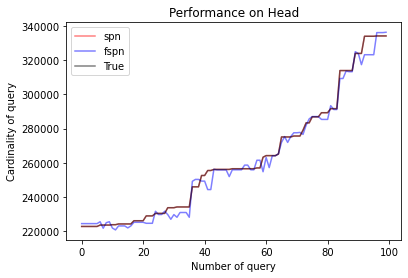

In [22]:
import matplotlib.pyplot as plt
x = np.arange(100)
idx = np.argsort(true_card)
plt.plot(x, card[idx[700:800]], color="red", alpha=0.5, label = "spn")
plt.plot(x, card2[idx[700:800]], color="blue", alpha=0.5, label = "fspn")
plt.plot(x, true_card[idx[700:800]], color="black", alpha=0.5, label = "True")
plt.xlabel("Number of query")
plt.ylabel("Cardinality of query")
plt.title("Performance on Head")
plt.legend()
plt.show()